# **Sentiment Analysis for Investment Strategies on Tesla Stock**

# 2. News Classification with Prompt Engineering Flan-T5
After some manual labeling work, nearly half of the news articles were not directly related to Tesla. The news from NewsAPI were extracted based on some key words, such as Tesla and Elon Musk. Therefore, there were news about Elon Musk's personal affairs, his personality, Musk's other companies and his opinion on some sensitive political issues. To me, those news were not directly related to Tesla performance and I assumed that they had subtle impact on Tesla's stock movements.

A classification tool is needed here to classify if a news article is directly related to Tesla or Not. Using LLMs is a good choice for this task since they have been trained with large amount of data with a good understanding of English context. However, for this particular classification task, some additional work is required to guide the chosen LLM to provide satisfactory results. The following methods have the potential to facilitate a LLM to achieve better results for a particular task:
* **Prompt Engineering or In-Context Learning (ICL)**
* **Fine-tuning**

Considering the limited size of data (207 news with labels), prompt engineering was tested in this notebook for the following models:
* **BERT** <span style='color:red'>(ICL supposed not work since it doesn't have generative capabilities)</span>
* **Flan-T5** <span style='color:green'>(ICL supposed to work)<span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, pipeline

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report

import time
import random

## 2.1. Data Preperation
News articles with manual labels are required for ICL for LLMs.  

Load the data with manual lables and perform some data wrangling as needed.

In [152]:
# read in data with manual labels
df_model = pd.read_csv('../data/Tesla_news_manual_labels.csv', index_col = 0, encoding = 'latin1')
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes


In [153]:
df_model.tail()

,source_name,author,date,title,description,content,label,tesla_related
202,TechRadar,Leon Poultney,10/9/2023,Tesla software update can help its car cameras...,Tesla software update 2023.32 brings with it g...,"Reversing into a trashcan, squashing your neig...",positive,yes
203,Breitbart News,"Paul Bois, Paul Bois",10/9/2023,Elon Musk Deletes Several Tweets After Promoti...,Elon Musk deleted several posts on his platfor...,Billionaire and X owner Elon Musk deleted seve...,negative,no
204,Business Insider,Alexa St. John,10/11/2023,Rivian CEO says he wouldn't buy the Cybertruck...,Rivian CEO RJ Scaringe spoke with GQ magazine ...,Carlos Delgado/Associated Press\n<ul><li>Rivia...,neutral,yes
205,Fortune,Prarthana Prakash,10/11/2023,"Bernard Arnault, the world's second richest ma...",LVMH boss Bernard Arnault's wealth topped $200...,Big gains in luxury spending helped LVMH boss ...,neutral,no
206,Reuters,Giulio Piovaccari,10/11/2023,"Ford, Hyundai turn to Italian casting machine ...","Idra, an Italian aluminium casting machine mak...","TRAVAGLIATO, Italy, Oct 11 (Reuters) - Idra, a...",neutral,yes


In [154]:
# check for missing values and data types
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source_name    207 non-null    object
 1   author         207 non-null    object
 2   date           207 non-null    object
 3   title          207 non-null    object
 4   description    207 non-null    object
 5   content        207 non-null    object
 6   label          207 non-null    object
 7   tesla_related  207 non-null    object
dtypes: object(8)
memory usage: 14.6+ KB


In [155]:
# label and tesla_related were generated manually
# first check if there were any manual errors
df_model.tesla_related.value_counts()

yes    116
no      91
Name: tesla_related, dtype: int64

<span style = "color:green">**Note:** Though the number of samples are limited but we have balanced classes for this binary classification.</span>

In [156]:
df_model.label.value_counts()

neutral     84
negative    63
positive    59
neagtive     1
Name: label, dtype: int64

In [157]:
# correct the mannual errors in sentiment analysis labels
df_model['label'] = df_model['label'].replace('neagtive', 'negative')

In [158]:
df_model.label.value_counts()

neutral     84
negative    64
positive    59
Name: label, dtype: int64

<span style = "color:green">**Note:** Sentiment labels are also overall balanced, especially between positive and negative.</span>

### Convert text labels to numeric:
* `Related to Tesla` : 1, `Not related to Tesla` : 0
* `positive` : 2, `neutral` : 1, `negative` : 0

In [2]:
# next change the labels to numbers
def binary_convert(x):
    if x == 'yes':
        return 1
    else:
        return 0

In [3]:
def sentiment_convert(x):
    if x == 'positive':
        return 2
    elif x == 'negative':
        return 0
    else:
        return 1

In [161]:
df_model['tesla_related_num'] = df_model['tesla_related'].apply(binary_convert)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,1
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,1
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,0
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,0
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,1


In [162]:
df_model['sentiment_label_num'] = df_model['label'].apply(sentiment_convert)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,1,1
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,1,0
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,0,1
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,0,1
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,1,2


In [163]:
# the manual labeling is mainly based on title and description
# create title + description for the classification task
df_model['title_desc'] = df_model['title'].map(str) + ' ' + df_model['description'].map(str)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,1,1,How Elon Musk lost a friend over AI: Google co...
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,1,0,Bill Gates Tries to Profit by Driving Down Tes...
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,0,1,Putin hails Elon Musk as an 'outstanding perso...
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,0,1,"What do donkeys, dragons and Hawaii have in co..."
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,1,2,Elon Musks supercomputer Dojo added $70 billi...


In [164]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_name          207 non-null    object
 1   author               207 non-null    object
 2   date                 207 non-null    object
 3   title                207 non-null    object
 4   description          207 non-null    object
 5   content              207 non-null    object
 6   label                207 non-null    object
 7   tesla_related        207 non-null    object
 8   tesla_related_num    207 non-null    int64 
 9   sentiment_label_num  207 non-null    int64 
 10  title_desc           207 non-null    object
dtypes: int64(2), object(9)
memory usage: 19.4+ KB


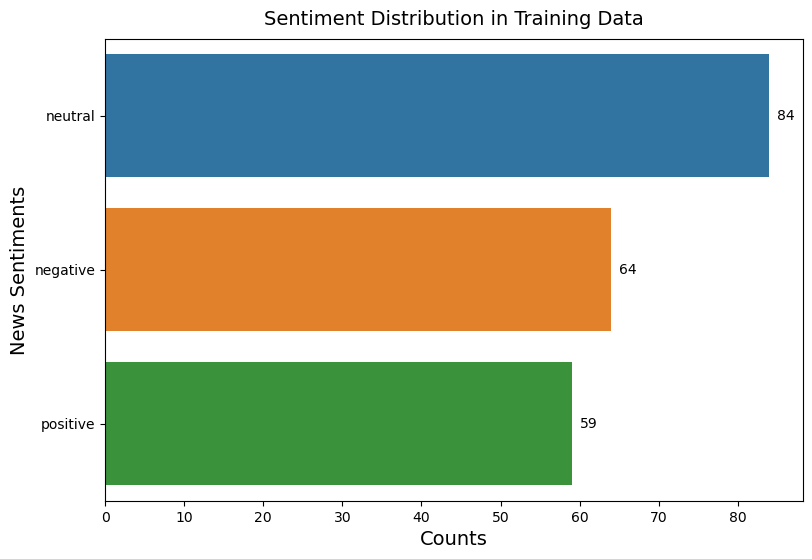

In [15]:
# plot the counts for each label
plt.figure(figsize= (9, 6))

ax = sns.countplot(data = df_model, y = 'label')

for patch in ax.patches:
    width = patch.get_width()
    ax.text(width+1,
            patch.get_y() + patch.get_height() / 2,
            format(width, '1.0f'),
            va = 'center')
plt.title('Sentiment Distribution in Training Data', fontsize = 14, pad = 10)    
plt.ylabel('News Sentiments', fontsize = 14)
plt.xlabel('Counts', fontsize = 14)
plt.show()

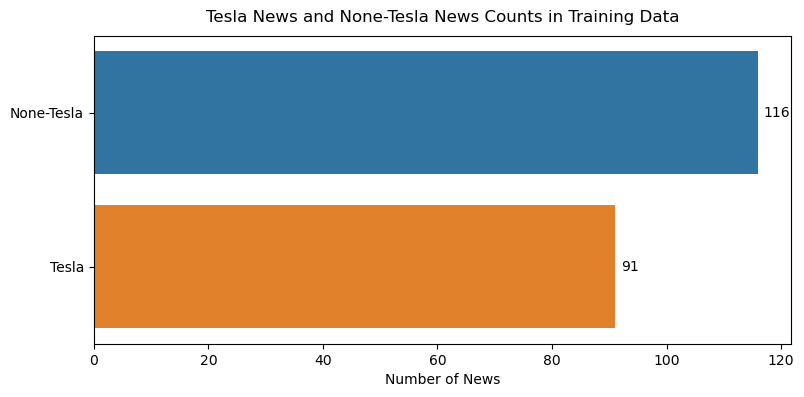

In [16]:
# plot the counts for each label
plt.figure(figsize = (9, 4))

ax = sns.countplot(data = df_model, y = 'tesla_related')

for patch in ax.patches:
    width = patch.get_width()
    ax.text(width + 1,
            patch.get_y() + patch.get_height() / 2,
            format(width, '1.0f'),
            va = 'center')

plt.title('Tesla News and None-Tesla News Counts in Training Data', pad = 10)    
plt.yticks([0, 1], ['None-Tesla', 'Tesla'])
plt.ylabel(None)
plt.xlabel('Number of News')
plt.show()

### Train / Validation Split

This step is **NOT** necessary for ICL. 

In [52]:
# randomize the data before splitting
df_train = df_model[['title_desc', 'tesla_related_num', 'sentiment_label_num']].sample(n = int(df_model.shape[0]*0.8), random_state = 21)
df_val = df_model[['title_desc', 'tesla_related_num', 'sentiment_label_num']].drop(df_train.index)
df_train.shape, df_val.shape

((165, 3), (42, 3))

In [54]:
df_train.sentiment_label_num.value_counts()

1    67
0    53
2    45
Name: sentiment_label_num, dtype: int64

In [55]:
df_val.sentiment_label_num.value_counts()

1    17
2    14
0    11
Name: sentiment_label_num, dtype: int64

In [56]:
df_train.tesla_related_num.value_counts()

1    96
0    69
Name: tesla_related_num, dtype: int64

In [57]:
df_val.tesla_related_num.value_counts()

0    22
1    20
Name: tesla_related_num, dtype: int64

In [97]:
df_train = df_train.reset_index(drop = True)
df_train.head()

,title_desc,tesla_related_num,sentiment_label_num
0,AOC says she's looking to trade in her Tesla f...,1,0
1,"Mercedes-Benz's $100,000 electric SUV is an aw...",1,1
2,Where is the phone?' Huawei keeps quiet about ...,1,1
3,Elon Musk sent a graphic mid-childbirth pictur...,0,1
4,Did Elon Musk Turn Off Starlink for Ukraine? W...,0,1


In [98]:
df_val = df_val.reset_index(drop = True)
df_val.head()

,title_desc,tesla_related_num,sentiment_label_num
0,Elon Musks supercomputer Dojo added $70 billi...,1,2
1,Elon Musk's biographer says Musk has 'multiple...,0,1
2,Elon Musk biography contains inaccurate tale o...,0,1
3,During the most concentrated pain in his lif...,1,2
4,Tesla Semi Shows Real World Payload and Range ...,1,2


## 2.2. In-Context Learning for BERT
<span style='color:red'>**ICL is not supposed to work for BERT model since it is a sequence classification model without generative capabilities.**</span>

The following test proves the idea above.

In [5]:
# load tokenizer and model
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [63]:
# create a pipeline
classification = pipeline("text-classification", model = model, tokenizer = tokenizer)

In [66]:
# test the model on the first 5 news
dash_line = '-'*200
for i in range(5):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']
    
    inputs = tokenizer(context, return_tensors = 'pt')
    output = classification(context)
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
Model output: [{'label': 'LABEL_0', 'score': 0.7095326781272888}]
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
Model output: [{'label': 'LABEL_0', 'score': 0.7308610081672668}]
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 3
Model output: [{'label': 'LABEL_0', 'score': 0.6396608948707581}]
True label: 1
----------------------------------------------------------------------------------------------------------------------------------------

In [70]:
# test the model on the first 5 news
dash_line = '-'*200
for i in range(5):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']
    
    inputs = tokenizer(context, return_tensors = 'pt')
    output = model(**inputs)
    predictions = torch.nn.functional.softmax(output.logits, dim = -1)
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'Model output: {output}')
    print(f'Model predictions: {predictions}')
    print(f'True label: {true_label}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
Model output: SequenceClassifierOutput(loss=None, logits=tensor([[ 0.8780, -0.0151]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Model predictions: tensor([[0.7095, 0.2905]], grad_fn=<SoftmaxBackward0>)
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
Model output: SequenceClassifierOutput(loss=None, logits=tensor([[ 0.9012, -0.0978]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Model predictions: tensor([[0.7309, 0.2691]], grad_fn=<SoftmaxBackward0>)
True label: 1
------------------------------------------------------------------------------------------------------------

**Note:** 
* The pipeline directly provides the classification labels and scores after softmax.
* Raw BERT model doesn't work well for this classification task. The predictions don't match the true labels for the majority of the test news.

### Zero-shot learning for BERT

In [69]:
# test the model on the first 5 news
dash_line = '-'*200
for i in range(5):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']
    
    prompt = f"""
    Classify if the news is related to Tesla or not.
    {context}
    Classification output:
    """
    
    output = classification(prompt)
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
Model output: [{'label': 'LABEL_0', 'score': 0.7120248675346375}]
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
Model output: [{'label': 'LABEL_0', 'score': 0.7431051135063171}]
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 3
Model output: [{'label': 'LABEL_0', 'score': 0.7346608638763428}]
True label: 1
----------------------------------------------------------------------------------------------------------------------------------------

<span style='color:red'>**Zero-shot learning doesn't change the BERT predictions much.**</span>

## 2.3. In-Context Learning for Flan-T5

FLAN-T5 is a LLM developed by Google to handle text2text generation tasks, such as translation and summarization.

The model size is 248M parameters.

<span style='color:green'>**ICL is supposed to work for the Flan-T5 model.**</span>

### 2.3.1. Load the Tokenizer and Model

In [21]:
model_name = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

### 2.3.2. Flan-T5 without ICL

In [77]:
# test the model on the first 5 news
dash_line = '-'*200
for i in range(5):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']

    inputs = tokenizer(context, return_tensors = 'pt')
    output = tokenizer.decode(
        model.generate(inputs['input_ids'])[0],
        skip_special_tokens = True
    )
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
Model output: Elon Musk has reportedly vowed to make a "safer" deal
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
Model output: Mercedes-Benz's EQE SUV is an awesome Tesla rival  but its 
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 3
Model output: China's rumored rumours of the Mate 60 Pro smartphone are 
True label: 1
-----------------------------------------------------------------------------------------------------------------------

**Note: The Flan-T5 model tried to summarize the news in its outputs.**

### 2.3.3. Zero-shot Learning

In [76]:
# test the model on the first 10 news
dash_line = '-'*200
for i in range(5):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']
    
    prompt = f"""
    Classify if the news is related to Tesla or not.
    {context}
    Classification output:
    """
    inputs = tokenizer(prompt, return_tensors = 'pt')
    output = tokenizer.decode(
        model.generate(inputs['input_ids'])[0],
        skip_special_tokens = True
    )
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

C:\Users\wfei2\anaconda3\lib\site-packages\transformers\generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
Model output: Not
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
Model output: Not
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 3
Model output: not
True label: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 4
Model output: Not
True label: 0
----------------------------------------

**Note: Without giving any example, the model was confused with what the output should be for this classification task.**

### 2.3.4. One-shot Learning

In [4]:
# to do one-shot or few-shot learning
# define a function to create the prompt
def make_prompt(examples, new):
    prompt = ''
    for i in range(examples.shape[0]):
        context = examples.iloc[i]['title_desc']
        true_label = examples.iloc[i]['tesla_related_num']
        if true_label == 0:
            label = 'No, it is not related to Tesla.'
        else:
            label = 'Yes, it is related to Tesla.'
            
        prompt += f"""
        Context from news:
        {context}
        Is the context related to Tesla?
        {label}
        """
    prompt += f"""
    Context from news:
    {new}
    Is the context related to Tesla?
    """
    return prompt

In [94]:
# test the model on the first 6 news, first one as the example
dash_line = '-'*200

for i in range(1, 6):
    context = df_train.iloc[i]['title_desc']
    true_label = df_train.iloc[i]['tesla_related_num']
    
    prompt = make_prompt(df_train.head(1), context) 
    
    inputs = tokenizer(prompt, return_tensors = 'pt')
    output = tokenizer.decode(
        model.generate(inputs['input_ids'])[0],
        skip_special_tokens = True
    )
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'This is the prompt:\n {prompt}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 2
This is the prompt:
 
        Context from news:
        AOC says she's looking to trade in her Tesla for a union-made EV after clash with Elon Musk AOC reiterated on Face the Nation on Sunday that she wants to trade in her Tesla for a union-made EV.
        Is the context related to Tesla?
        Yes, it is related to Tesla.
        
    Context from news:
    Mercedes-Benz's $100,000 electric SUV is an awesome Tesla rival  but its blob-like looks aren't for everyone The Mercedes EQE SUV is an awesome alternative to Tesla's Model X with controversial style.
    Is the context related to Tesla?
    
Model output: Yes
True label: 1
-------------------------------------------------------------------------------------------------------------------------------------------------------

**Note: By providing one task example in the prompt, the model started to show reasonable classification outputs.**

Since one-shot learning test looks promising, Let's check out one-shot learning for all data with manual labels.

In [174]:
# generate outputs for all training and validation data
def one_shot_class(data, index):
    example = data.loc[data.index.isin(index)]   
    for i in range(data.shape[0]):
        if i in index:
            continue
        try:
            context = data.iloc[i]['title_desc']
            true_label = data.iloc[i]['tesla_related_num']
    
            prompt = make_prompt(example, context) 
    
            inputs = tokenizer(prompt, return_tensors = 'pt')
            output = tokenizer.decode(
                model.generate(inputs['input_ids'], max_new_tokens = 20)[0],
                skip_special_tokens = True
            )
            data.loc[i, 'one_shot_class'] = output
        except:
            print(f'index {i} has error')
    return data

In [179]:
# select a random row as the one-shot
index_foricl = random.randrange(df_model.shape[0])
index_foricl

46

In [180]:
# perform one-shot classifications for all data
df_model = one_shot_class(df_model, [index_foricl])
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc,one_shot_class
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,1,1,How Elon Musk lost a friend over AI: Google co...,Yes
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,1,0,Bill Gates Tries to Profit by Driving Down Tes...,Yes
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,0,1,Putin hails Elon Musk as an 'outstanding perso...,No
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,0,1,"What do donkeys, dragons and Hawaii have in co...",No
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,1,2,Elon Musks supercomputer Dojo added $70 billi...,Yes


In [181]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_name          207 non-null    object
 1   author               207 non-null    object
 2   date                 207 non-null    object
 3   title                207 non-null    object
 4   description          207 non-null    object
 5   content              207 non-null    object
 6   label                207 non-null    object
 7   tesla_related        207 non-null    object
 8   tesla_related_num    207 non-null    int64 
 9   sentiment_label_num  207 non-null    int64 
 10  title_desc           207 non-null    object
 11  one_shot_class       206 non-null    object
dtypes: int64(2), object(10)
memory usage: 29.1+ KB


In [183]:
df_model[df_model.one_shot_class.isnull() == True]

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc,one_shot_class
46,Next Big Future,Brian Wang,9/15/2023,Tesla Breakthrough 3D Printing With Sand For S...,Reuters reports that Tesla has combined a seri...,Reuters reports that Tesla has combined a seri...,positive,yes,1,2,Tesla Breakthrough 3D Printing With Sand For S...,NaN


### 2.3.5. Few-shot Learning

In [108]:
# test the model on the first several news
dash_line = '-'*200

example = df_train[(df_train.index==0) | (df_train.index==3)]
df_test = df_train.drop(example.index).reset_index(drop = True)

for i in range(5):
    context = df_test.iloc[i]['title_desc']
    true_label = df_test.iloc[i]['tesla_related_num']
    
    prompt = make_prompt(example, context) 
    
    inputs = tokenizer(prompt, return_tensors = 'pt')
    output = tokenizer.decode(
        model.generate(inputs['input_ids'])[0],
        skip_special_tokens = True
    )
    
    print(dash_line)
    print(f'News {i+1}')
    print(f'This is the prompt:\n {prompt}')
    print(f'Model output: {output}')
    print(f'True label: {true_label}')

C:\Users\wfei2\anaconda3\lib\site-packages\transformers\generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
News 1
This is the prompt:
 
        Context from news:
        AOC says she's looking to trade in her Tesla for a union-made EV after clash with Elon Musk AOC reiterated on Face the Nation on Sunday that she wants to trade in her Tesla for a union-made EV.
        Is the context related to Tesla?
        Yes, it is related to Tesla.
        
        Context from news:
        Elon Musk sent a graphic mid-childbirth picture of Grimes to friends and family and was surprised when she got upset When Musk shared the photo with Grimes father and brothers, she said It was his Aspergers coming out in full.
        Is the context related to Tesla?
        No, it is not related to Tesla.
        
    Context from news:
    Mercedes-Benz's $100,000 electric SUV is an awesome Tesla rival  but i

**Note: Few-shot learning also worked for this task. From testing on just 5 samples, few-shot (2 shots) learning accuracy was comparable to one-shot learning.**

Let's try few-shot learning for all data with munual labels. 

Will try different shots for few-shot learning, including 2 shots, 3 shots, 4 shots and 5 shots. From other people's experience, few-shot learning doesn't see much improvements with more than 5 shots.

In [191]:
# generate outputs for all training and validation data
def few_shot_class(data, index, shots):
    if len(index) != shots:
        raise InputError('Inconsistent index number and shot number for learning.')
    example = data.loc[data.index.isin(index)]   
    for i in range(data.shape[0]):
        if i in index:
            continue
        try:
            context = data.iloc[i]['title_desc']
            true_label = data.iloc[i]['tesla_related_num']
    
            prompt = make_prompt(example, context) 
    
            inputs = tokenizer(prompt, return_tensors = 'pt')
            output = tokenizer.decode(
                model.generate(inputs['input_ids'], max_new_tokens = 20)[0],
                skip_special_tokens = True
            )
            col = 'few_shot_class_'+str(shots)
            data.loc[i, col] = output
        except:
            print(f'index {i} has error')
    return data

In [194]:
# let check few-shots with 2 shots, 3 shots, 4 shots and 5 shots
for shots in range(2, 6):
    num_list = [random.randrange(df_one.shape[0]) for _ in range(shots)]
    print(num_list)
    df_one = few_shot_class(df_one, num_list, shots)
df_one.head()

[43, 96]
[66, 58, 181]
[201, 37, 0, 98]
[178, 192, 202, 11, 155]


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc,one_shot_class,few_shot_class_2,few_shot_class_3,few_shot_class_4,few_shot_class_5
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,1,1,How Elon Musk lost a friend over AI: Google co...,Yes,"No, it is not related to Tesla.","Yes, it is related to Tesla.",NaN,"No, it is not possible to tell"
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,1,0,Bill Gates Tries to Profit by Driving Down Tes...,Yes,"No, it is not related to Tesla.","Yes, it is related to Tesla.","Yes, it is related to Tesla.","No, it is not possible to tell"
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,0,1,Putin hails Elon Musk as an 'outstanding perso...,No,"No, it is not related to Tesla.",No,No,No
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,0,1,"What do donkeys, dragons and Hawaii have in co...",No,"No, it is not related to Tesla.",No,No,"No, it is not possible to tell"
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,1,2,Elon Musks supercomputer Dojo added $70 billi...,Yes,Yes,"Yes, it is related to Tesla.",Yes,"Yes, it is related to Tesla."


In [195]:
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_name          207 non-null    object
 1   author               207 non-null    object
 2   date                 207 non-null    object
 3   title                207 non-null    object
 4   description          207 non-null    object
 5   content              207 non-null    object
 6   label                207 non-null    object
 7   tesla_related        207 non-null    object
 8   tesla_related_num    207 non-null    int64 
 9   sentiment_label_num  207 non-null    int64 
 10  title_desc           207 non-null    object
 11  one_shot_class       206 non-null    object
 12  few_shot_class_2     205 non-null    object
 13  few_shot_class_3     204 non-null    object
 14  few_shot_class_4     203 non-null    object
 15  few_shot_class_5     202 non-null    object
dtypes: int64

In [197]:
df_one.to_csv('../data/Tesla_news_Flan_T5_labels.csv', index = False)
df_one = pd.read_csv('../data/Tesla_news_Flan_T5_labels.csv')
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_name          207 non-null    object
 1   author               207 non-null    object
 2   date                 207 non-null    object
 3   title                207 non-null    object
 4   description          207 non-null    object
 5   content              207 non-null    object
 6   label                207 non-null    object
 7   tesla_related        207 non-null    object
 8   tesla_related_num    207 non-null    int64 
 9   sentiment_label_num  207 non-null    int64 
 10  title_desc           207 non-null    object
 11  one_shot_class       206 non-null    object
 12  few_shot_class_2     205 non-null    object
 13  few_shot_class_3     204 non-null    object
 14  few_shot_class_4     203 non-null    object
 15  few_shot_class_5     202 non-null    object
dtypes: int64

In [6]:
df_one = pd.read_csv('../data/Tesla_news_Flan_T5_labels.csv')
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_name          207 non-null    object
 1   author               207 non-null    object
 2   date                 207 non-null    object
 3   title                207 non-null    object
 4   description          207 non-null    object
 5   content              207 non-null    object
 6   label                207 non-null    object
 7   tesla_related        207 non-null    object
 8   tesla_related_num    207 non-null    int64 
 9   sentiment_label_num  207 non-null    int64 
 10  title_desc           207 non-null    object
 11  one_shot_class       206 non-null    object
 12  few_shot_class_2     205 non-null    object
 13  few_shot_class_3     204 non-null    object
 14  few_shot_class_4     203 non-null    object
 15  few_shot_class_5     202 non-null    object
dtypes: int64

## 2.4. Evaluation of Different ICLs for Flan-T5
The following ICL results are evaluated and compared here:
* One-shot learning
* Few-shot learning: 2 shots, 3 shots, 4 shots, 5 shots 

### 2.4.1. Check for Issues and Correct Them

In [7]:
# first look at one-shot output
df_one.one_shot_class.value_counts()

Yes    109
No      96
no       1
Name: one_shot_class, dtype: int64

In [8]:
df_one['one_shot_class'] = df_one['one_shot_class'].replace(['Yes', 'No'], ['yes', 'no'])
df_one.one_shot_class.value_counts()

yes    109
no      97
Name: one_shot_class, dtype: int64

In [9]:
# 2-shots outputs
df_one.few_shot_class_2.value_counts()

No, it is not related to Tesla.    112
Yes                                 73
No                                  14
No, it is not possible to tell       6
Name: few_shot_class_2, dtype: int64

In [10]:
# let's take a look at those not possible to tell
df_one[df_one.few_shot_class_2 == 'No, it is not possible to tell']

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc,one_shot_class,few_shot_class_2,few_shot_class_3,few_shot_class_4,few_shot_class_5
66,Fortune,Christiaan Hetzner,9/18/2023,UAW boss says Big 3 can give their fair share ...,UAW boss Shawn Fain says after securing a deal...,Union leader Shawn Fain has a message for Elon...,negative,yes,1,0,UAW boss says Big 3 can give their fair share ...,yes,"No, it is not possible to tell",NaN,No,"No, it is not possible to tell"
82,Time,Isabella Ward and Marissa Newman / Bloomberg,9/19/2023,Elon Musk Weighs Charging Users a Monthly Fee ...,Elon Musk said a small monthly service fee for...,Elon Musk said that a small monthly service fe...,neutral,no,0,1,Elon Musk Weighs Charging Users a Monthly Fee ...,no,"No, it is not possible to tell",No,"No, it is not possible to tell","No, it is not possible to tell"
90,Business Insider,Beatrice Nolan,9/19/2023,'He simply wants to kill the platform': Some X...,Elon Musk has suggested yet another shakeup fo...,Elon Musk.Joel Saget/AFP via Getty Images\n<ul...,negative,no,0,0,'He simply wants to kill the platform': Some X...,no,"No, it is not possible to tell","No, it is not possible to tell","No, it is not possible to tell","No, it is not possible to tell"
113,Business Insider,Tim Levin,9/25/2023,AOC says she'll trade in her Tesla for a union...,There aren't many union-made electric cars on ...,Rep. Alexandria Ocasio-Cortez wants to trade i...,negative,yes,1,0,AOC says she'll trade in her Tesla for a union...,yes,"No, it is not possible to tell",No,No,No
151,Business Insider,Grace Kay,9/30/2023,"Elon Musk's dad, 77, says he'd have more kids ...","Elon Musk's father, Errol, has seven known chi...","Errol Musk, the father of Elon Musk, told Insi...",neutral,no,0,1,"Elon Musk's dad, 77, says he'd have more kids ...",no,"No, it is not possible to tell",No,No,"No, it is not possible to tell"
176,Business Insider,astjohn@insider.com (Alexa St. John),10/4/2023,The founder of Tesla's biggest China rival rep...,"The founder of Chinese automaker BYD, Tesla's ...","The founder of Chinese automaker BYD, Tesla's ...",neutral,yes,1,1,The founder of Tesla's biggest China rival rep...,yes,"No, it is not possible to tell",Yes,Yes,Yes


<span style = 'color:red'>**After few-shot learning, the model started to struggle to give correct classification results, like above.**</span>

In [109]:
# 3-shots outputs
df_one.few_shot_class_3.value_counts()

Yes, it is related to Tesla.       90
No                                 75
No, it is not possible to tell     24
Yes                                11
No, it is not related to Tesla.     2
Yes, it is related to Pepsi.        2
Name: few_shot_class_3, dtype: int64

In [110]:
# 4-shots outputs
df_one.few_shot_class_4.value_counts()

No                                 84
Yes                                61
Yes, it is related to Tesla.       27
No, it is not possible to tell     27
No, it is not related to Tesla.     2
Yes, it is related to Pepsi.        2
Name: few_shot_class_4, dtype: int64

In [111]:
# 5-shots outputs
df_one.few_shot_class_5.value_counts()

No, it is not possible to tell     73
Yes, it is related to Tesla.       73
No                                 30
No, it is not related to Tesla.    18
Yes                                 5
Yes, it is related to Pepsi.        3
Name: few_shot_class_5, dtype: int64

<span style='color:red'>**The more examples given, the model tended to be more easily confused and provided more "not possible to tell" outputs.**</span> 

**Let's assume:**
* all "not possible to tell" as "Not related to Tesla"
* all "related to Pepsi" as "Related to Tesla"

In [11]:
# correct the few-shot learning outputs for evaluation
df_one['few_shot_class_2'] = df_one['few_shot_class_2'].apply(lambda x: 'yes' if isinstance(x, str) and 'Yes' in x else ('no' if isinstance(x, str) and 'No' in x else x))
df_one.few_shot_class_2.value_counts()

no     132
yes     73
Name: few_shot_class_2, dtype: int64

In [12]:
df_one['few_shot_class_3'] = df_one['few_shot_class_3'].apply(lambda x: 'yes' if isinstance(x, str) and 'Yes' in x else ('no' if isinstance(x, str) and 'No' in x else x))
df_one.few_shot_class_3.value_counts()

yes    103
no     101
Name: few_shot_class_3, dtype: int64

In [13]:
df_one['few_shot_class_4'] = df_one['few_shot_class_4'].apply(lambda x: 'yes' if isinstance(x, str) and 'Yes' in x else ('no' if isinstance(x, str) and 'No' in x else x))
df_one.few_shot_class_4.value_counts()

no     113
yes     90
Name: few_shot_class_4, dtype: int64

In [14]:
df_one['few_shot_class_5'] = df_one['few_shot_class_5'].apply(lambda x: 'yes' if isinstance(x, str) and 'Yes' in x else ('no' if isinstance(x, str) and 'No' in x else x))
df_one.few_shot_class_5.value_counts()

no     121
yes     81
Name: few_shot_class_5, dtype: int64

### 2.4.2. Classification Report Comparison

In [130]:
cr_1sh = classification_report(df_one.loc[~df_one['one_shot_class'].isnull(), 'tesla_related'], df_one.loc[~df_one['one_shot_class'].isnull(), 'one_shot_class'])
print(cr_1sh)

              precision    recall  f1-score   support

          no       0.81      0.87      0.84        91
         yes       0.89      0.84      0.87       115

    accuracy                           0.85       206
   macro avg       0.85      0.86      0.85       206
weighted avg       0.86      0.85      0.85       206



In [126]:
cr_2sh = classification_report(df_one.loc[~df_one['few_shot_class_2'].isnull(), 'tesla_related'], df_one.loc[~df_one['few_shot_class_2'].isnull(), 'few_shot_class_2'])
print(cr_2sh)

              precision    recall  f1-score   support

          no       0.66      0.98      0.79        89
         yes       0.97      0.61      0.75       116

    accuracy                           0.77       205
   macro avg       0.82      0.79      0.77       205
weighted avg       0.84      0.77      0.77       205



In [127]:
cr_3sh = classification_report(df_one.loc[~df_one['few_shot_class_3'].isnull(), 'tesla_related'], df_one.loc[~df_one['few_shot_class_3'].isnull(), 'few_shot_class_3'])
print(cr_3sh)

              precision    recall  f1-score   support

          no       0.79      0.88      0.83        91
         yes       0.89      0.81      0.85       113

    accuracy                           0.84       204
   macro avg       0.84      0.85      0.84       204
weighted avg       0.85      0.84      0.84       204



In [128]:
cr_4sh = classification_report(df_one.loc[~df_one['few_shot_class_4'].isnull(), 'tesla_related'], df_one.loc[~df_one['few_shot_class_4'].isnull(), 'few_shot_class_4'])
print(cr_4sh)

              precision    recall  f1-score   support

          no       0.75      0.94      0.84        90
         yes       0.94      0.75      0.84       113

    accuracy                           0.84       203
   macro avg       0.85      0.85      0.84       203
weighted avg       0.86      0.84      0.84       203



In [129]:
cr_5sh = classification_report(df_one.loc[~df_one['few_shot_class_5'].isnull(), 'tesla_related'], df_one.loc[~df_one['few_shot_class_5'].isnull(), 'few_shot_class_5'])
print(cr_5sh)

              precision    recall  f1-score   support

          no       0.70      0.94      0.81        90
         yes       0.94      0.68      0.79       112

    accuracy                           0.80       202
   macro avg       0.82      0.81      0.80       202
weighted avg       0.83      0.80      0.80       202



<span style='color: green'>**Summary:**</span>
* One-shot learning showed the best performance with highest accuracy (for balanced binary classes).
* Including more examples in the prompt (few-shot learning) didn't improve the overall accuracy.
* Few-shot learning showed high precision for 'yes' and high recall for 'no'.
    * high precision for 'yes' mean most predicted 'yes' are true 'yes', but there are possible true 'yes' predicted as 'no'.
    * high recall for 'no' mean most true 'no' are predicted as 'no', but there are possible true 'yes' predicted as 'no'.
* All few-shot learning suffered from mislabeling true 'yes' as 'no', which is a big issue for our sentiment analysis.
* There were additional assumptions made to intepret few-shot learning model outputs.
* For our sentiment analysis, better go with one-shot in-context learning Flan-T5 model.

In [133]:
# plot confusion matrix for one-shot learning
cm_1sh = confusion_matrix(df_one.loc[~df_one['one_shot_class'].isnull(), 'tesla_related'], df_one.loc[~df_one['one_shot_class'].isnull(), 'one_shot_class'])
cm_1sh

array([[79, 12],
       [18, 97]], dtype=int64)

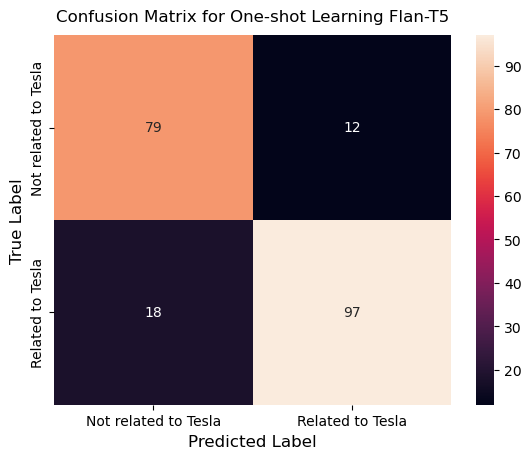

In [140]:
# define a function to plot confusion matrix
labels = ['Not related to Tesla', 'Related to Tesla']
sns.heatmap(cm_1sh, annot = True, xticklabels = labels, yticklabels = labels)

plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.title('Confusion Matrix for One-shot Learning Flan-T5', pad = 10)

plt.show()

## 2.5. Classification for All

In [15]:
# extract the example shot
example_shot = df_one[df_one['one_shot_class'].isnull()]
example_shot

,source_name,author,date,title,description,content,label,tesla_related,tesla_related_num,sentiment_label_num,title_desc,one_shot_class,few_shot_class_2,few_shot_class_3,few_shot_class_4,few_shot_class_5
46,Next Big Future,Brian Wang,9/15/2023,Tesla Breakthrough 3D Printing With Sand For S...,Reuters reports that Tesla has combined a seri...,Reuters reports that Tesla has combined a seri...,positive,yes,1,2,Tesla Breakthrough 3D Printing With Sand For S...,NaN,no,yes,yes,yes


In [16]:
# modify the one_shot_class function
def one_shot_class_m(data, example):
    for i in range(data.shape[0]):
        try:
            context = data.iloc[i]['title_desc']
            prompt = make_prompt(example, context) 
    
            inputs = tokenizer(prompt, return_tensors = 'pt')
            output = tokenizer.decode(
                model.generate(inputs['input_ids'], max_new_tokens = 20)[0],
                skip_special_tokens = True
            )
            data.loc[i, 'one_shot_class'] = output
        except:
            print(f'index {i} has error')
    return data

In [17]:
# read in the rest of data without manual labels
df_rest = pd.read_csv('../data/Tesla_news_no_labels.csv', encoding = 'latin1', index_col = 0)
df_rest.head()

,source_name,author,date,title,description,content
0,Business Insider,ssheth@businessinsider.com (Sonam Sheth),9/12/2023,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ..."
1,Fortune,Paige Hagy,9/12/2023,Elon Musk lives life like hes playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...
2,CNN,Paul Glader,9/12/2023,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ..."
3,Business Insider,Grace Dean,9/12/2023,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...
4,Financial Post,Bloomberg News,9/12/2023,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...


In [18]:
# create `title_desc` col
df_rest['title_desc'] = df_rest['title'].map(str) + ' ' + df_rest['description'].map(str)
df_rest.tail()

,source_name,author,date,title,description,content,title_desc
133,Newsweek,Eileen Falkenberg-Hull,10/9/2023,Partnership Has Mercedes Reimagining Space Tra...,A partnership between Mercedes-Maybach and Spa...,There's no Mercedes floating around in Space l...,Partnership Has Mercedes Reimagining Space Tra...
134,Reuters,Chris Prentice,10/9/2023,Analysis: Why the SEC might win its latest bat...,The U.S. Securities and Exchange Commission (S...,"WASHINGTON, Oct 9 (Reuters) - The U.S. Securit...",Analysis: Why the SEC might win its latest bat...
135,News24,news24,10/9/2023,News24 | A list of Elon Musk's legal entanglem...,Here's a look at Elon Musk's growing legal cha...,<ul><li>Below is a list of Elon Musk's legal e...,News24 | A list of Elon Musk's legal entanglem...
136,The Irish Times,Proinsias O'Mahony,10/10/2023,Magnificent seven stocks are keeping indices a...,"While the S&P 500 is still up 11% this year, i...",The so-called magnificent seven tech giants Ap...,Magnificent seven stocks are keeping indices a...
137,Business Insider,psyme@insider.com (Pete Syme),10/11/2023,Tesla rejected a major union's claims of healt...,Tesla workers at the Berlin Gigafactory have s...,Tesla has denied accusations from a German uni...,Tesla rejected a major union's claims of healt...


In [19]:
df_rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_name  138 non-null    object
 1   author       135 non-null    object
 2   date         138 non-null    object
 3   title        138 non-null    object
 4   description  138 non-null    object
 5   content      138 non-null    object
 6   title_desc   138 non-null    object
dtypes: object(7)
memory usage: 8.6+ KB


In [23]:
# get classification labels
df_rest = one_shot_class_m(df_rest, example_shot)
df_rest.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class
0,Business Insider,ssheth@businessinsider.com (Sonam Sheth),9/12/2023,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ...",Elon Musk learned hypnosis as a child and mana...,Yes
1,Fortune,Paige Hagy,9/12/2023,Elon Musk lives life like hes playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...,Elon Musk lives life like hes playing a video...,No
2,CNN,Paul Glader,9/12/2023,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,No
3,Business Insider,Grace Dean,9/12/2023,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...,After Elon Musk spoke to Neuralink director Sh...,No
4,Financial Post,Bloomberg News,9/12/2023,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,Tesla gets $80-billion boost from analyst call...,Yes


In [24]:
df_rest.one_shot_class.value_counts()

Yes                              75
No                               61
Yes, it is related to Oracle.     1
no                                1
Name: one_shot_class, dtype: int64

In [25]:
# correct the outputs to 'yes' and 'no'
df_rest['one_shot_class'] = df_rest['one_shot_class'].apply(lambda x: 'yes' if isinstance(x, str) and 'Yes' in x else ('no' if isinstance(x, str) and 'No' in x else x))
df_rest.one_shot_class.value_counts()

yes    76
no     62
Name: one_shot_class, dtype: int64

In [26]:
# combine the two datasets
cols1 = ['source_name', 'author', 'date', 'title', 'description', 'content', 'title_desc', 'one_shot_class', 'tesla_related', 'label']
cols2 = ['source_name', 'author', 'date', 'title', 'description', 'content', 'title_desc', 'one_shot_class']
df_merge = pd.concat([df_one[cols1], df_rest[cols2]])
df_merge.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,Bill Gates Tries to Profit by Driving Down Tes...,yes,yes,negative
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,Putin hails Elon Musk as an 'outstanding perso...,no,no,neutral
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,"What do donkeys, dragons and Hawaii have in co...",no,no,neutral
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,Elon Musks supercomputer Dojo added $70 billi...,yes,yes,positive


In [27]:
# sort the merged data based on `date` and reset index
df_merge['date'] = pd.to_datetime(df_merge['date'])
df_merge = df_merge.sort_values(by = ['date'])
df_merge = df_merge.reset_index(drop = True)
df_merge.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN
2,Business Insider,Grace Dean,2023-09-12,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...,After Elon Musk spoke to Neuralink director Sh...,no,NaN,NaN
3,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,Tesla gets $80-billion boost from analyst call...,yes,NaN,NaN
4,CNN,"Catherine Thorbecke, CNN",2023-09-12,Tesla shares jump after Morgan Stanley predict...,Teslas Dojo supercomputer could fuel a $500 b...,Teslas Dojo supercomputer could fuel a $500 bi...,Tesla shares jump after Morgan Stanley predict...,yes,NaN,NaN


In [28]:
df_merge.tail()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
340,The Irish Times,Proinsias O'Mahony,2023-10-10,Magnificent seven stocks are keeping indices a...,"While the S&P 500 is still up 11% this year, i...",The so-called magnificent seven tech giants Ap...,Magnificent seven stocks are keeping indices a...,no,NaN,NaN
341,Fortune,Prarthana Prakash,2023-10-11,"Bernard Arnault, the world's second richest ma...",LVMH boss Bernard Arnault's wealth topped $200...,Big gains in luxury spending helped LVMH boss ...,"Bernard Arnault, the world's second richest ma...",no,no,neutral
342,Business Insider,Alexa St. John,2023-10-11,Rivian CEO says he wouldn't buy the Cybertruck...,Rivian CEO RJ Scaringe spoke with GQ magazine ...,Carlos Delgado/Associated Press\n<ul><li>Rivia...,Rivian CEO says he wouldn't buy the Cybertruck...,yes,yes,neutral
343,Reuters,Giulio Piovaccari,2023-10-11,"Ford, Hyundai turn to Italian casting machine ...","Idra, an Italian aluminium casting machine mak...","TRAVAGLIATO, Italy, Oct 11 (Reuters) - Idra, a...","Ford, Hyundai turn to Italian casting machine ...",yes,yes,neutral
344,Business Insider,psyme@insider.com (Pete Syme),2023-10-11,Tesla rejected a major union's claims of healt...,Tesla workers at the Berlin Gigafactory have s...,Tesla has denied accusations from a German uni...,Tesla rejected a major union's claims of healt...,yes,NaN,NaN


In [29]:
# check for missing values
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source_name     345 non-null    object        
 1   author          342 non-null    object        
 2   date            345 non-null    datetime64[ns]
 3   title           345 non-null    object        
 4   description     345 non-null    object        
 5   content         345 non-null    object        
 6   title_desc      345 non-null    object        
 7   one_shot_class  344 non-null    object        
 8   tesla_related   207 non-null    object        
 9   label           207 non-null    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 27.1+ KB


In [30]:
# fillin the missing one for the example
df_merge.loc[df_merge['one_shot_class'].isnull(), 'one_shot_class'] = df_merge.loc[df_merge['one_shot_class'].isnull(), 'tesla_related']
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source_name     345 non-null    object        
 1   author          342 non-null    object        
 2   date            345 non-null    datetime64[ns]
 3   title           345 non-null    object        
 4   description     345 non-null    object        
 5   content         345 non-null    object        
 6   title_desc      345 non-null    object        
 7   one_shot_class  345 non-null    object        
 8   tesla_related   207 non-null    object        
 9   label           207 non-null    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 27.1+ KB


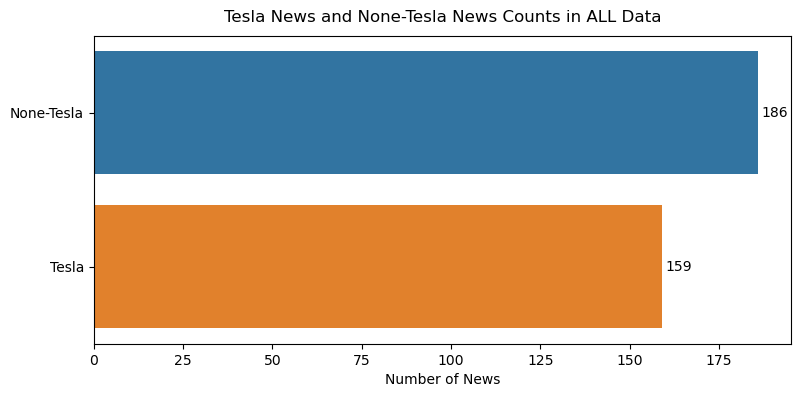

In [31]:
# plot the counts for each label
plt.figure(figsize = (9, 4))

ax = sns.countplot(data = df_merge, y = 'one_shot_class')

for patch in ax.patches:
    width = patch.get_width()
    ax.text(width + 1,
            patch.get_y() + patch.get_height() / 2,
            format(width, '1.0f'),
            va = 'center')

plt.title('Tesla News and None-Tesla News Counts in ALL Data', pad = 10)    
plt.yticks([0, 1], ['None-Tesla', 'Tesla'])
plt.ylabel(None)
plt.xlabel('Number of News')
plt.show()

In [32]:
# save the output
df_merge.to_csv('../data/News_Classification_One_Class.csv', index = False)

In [33]:
# check the saved data
df_check = pd.read_csv('../data/News_Classification_One_Class.csv')
df_check.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN
2,Business Insider,Grace Dean,2023-09-12,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...,After Elon Musk spoke to Neuralink director Sh...,no,NaN,NaN
3,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,Tesla gets $80-billion boost from analyst call...,yes,NaN,NaN
4,CNN,"Catherine Thorbecke, CNN",2023-09-12,Tesla shares jump after Morgan Stanley predict...,Teslas Dojo supercomputer could fuel a $500 b...,Teslas Dojo supercomputer could fuel a $500 bi...,Tesla shares jump after Morgan Stanley predict...,yes,NaN,NaN


In [34]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source_name     345 non-null    object
 1   author          342 non-null    object
 2   date            345 non-null    object
 3   title           345 non-null    object
 4   description     345 non-null    object
 5   content         345 non-null    object
 6   title_desc      345 non-null    object
 7   one_shot_class  345 non-null    object
 8   tesla_related   207 non-null    object
 9   label           207 non-null    object
dtypes: object(10)
memory usage: 27.1+ KB
